In [2]:
from huggingface_hub import hf_hub_download
import huggingface_hub as hf
import pickle
from pprint import pprint
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk
from transformers import BertForMaskedLM, AutoTokenizer

/home/krrish/Desktop/Programming/geneformer-scratch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Working with the datasets

In [4]:
MAIN_DATA = "data/genecorpus_30M_2048.dataset/dataset.arrow"
TOKEN_DICT = "data/token_dictionary.pkl"
SORTED_LENGTH = "data/genecorpus_30M_2048_sorted_lengths.pkl"
LENGTH = "data/genecorpus_30M_2048_lengths.pkl"
MAIN_PATH = "/home/krrish/Desktop/Programming/geneformer-scratch/"

In [5]:
# Load and inspect token dictionary
token_dict_path = os.path.join(MAIN_PATH, TOKEN_DICT)
with open(token_dict_path, "rb") as f:
    token_dict = pickle.load(f)

print("Token Dictionary:")
print(f"Type: {type(token_dict)}")
print(f"Length: {len(token_dict)}")
print("\nFirst 20 items:")
pprint(list(token_dict.items())[:20])

# Load and inspect lengths
lengths_path = os.path.join(MAIN_PATH, LENGTH)
with open(lengths_path, "rb") as f:
    lengths = pickle.load(f)

print("\n\nLengths:")
print(f"Type: {type(lengths)}")
print(f"Length: {len(lengths)}")
print(f"First 20 values: {lengths[:20]}")

# Load and inspect sorted lengths
sorted_length_path = os.path.join(MAIN_PATH, SORTED_LENGTH)
with open(sorted_length_path, "rb") as f:
    sorted_lengths = pickle.load(f)

print("\n\nSorted Lengths:")
print(f"Type: {type(sorted_lengths)}")
print(f"Length: {len(sorted_lengths)}")
print(f"First 20 values: {sorted_lengths[:20]}")

Token Dictionary:
Type: <class 'dict'>
Length: 25426

First 20 items:
[('<pad>', 0),
 ('<mask>', 1),
 ('ENSG00000000003', np.int16(2)),
 ('ENSG00000000005', np.int16(3)),
 ('ENSG00000000419', np.int16(4)),
 ('ENSG00000000457', np.int16(5)),
 ('ENSG00000000460', np.int16(6)),
 ('ENSG00000000938', np.int16(7)),
 ('ENSG00000000971', np.int16(8)),
 ('ENSG00000001036', np.int16(9)),
 ('ENSG00000001084', np.int16(10)),
 ('ENSG00000001167', np.int16(11)),
 ('ENSG00000001460', np.int16(12)),
 ('ENSG00000001461', np.int16(13)),
 ('ENSG00000001497', np.int16(14)),
 ('ENSG00000001561', np.int16(15)),
 ('ENSG00000001617', np.int16(16)),
 ('ENSG00000001626', np.int16(17)),
 ('ENSG00000001629', np.int16(18)),
 ('ENSG00000001630', np.int16(19))]


Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values: [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]


Sorted Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values:

In [7]:
# Optimizing the dataloader is going to be a big thing. Need to figure out the datatype. 

vocab_size = len(token_dict)
max_token_id = max(token_dict.values())

print(f"\nDtype requirements:")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Max token ID: {max_token_id:,}")


Dtype requirements:
  Vocab size: 25,426
  Max token ID: 25,425


We are going to use `int16` for everything. Just while calculating the embeddings need to be careful. 

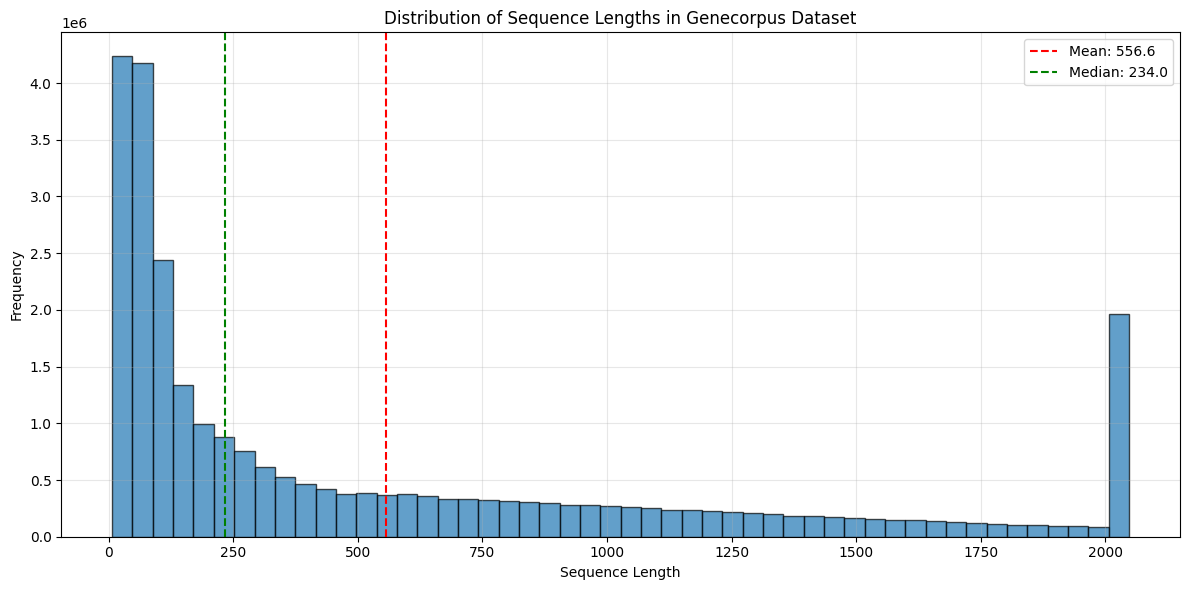

Sequence Length Statistics:
  Min: 7
  Max: 2048
  Mean: 556.56
  Median: 234.00
  Std Dev: 639.62
  25th percentile: 74.00
  75th percentile: 897.00
  95th percentile: 2048.00
  99th percentile: 2048.00


In [15]:
# Create histogram of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in Genecorpus Dataset')
plt.grid(True, alpha=0.3)

# Add statistics
mean_len = np.mean(lengths)
median_len = np.median(lengths)
max_len = np.max(lengths)
min_len = np.min(lengths)

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Sequence Length Statistics:")
print(f"  Min: {min_len}")
print(f"  Max: {max_len}")
print(f"  Mean: {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std Dev: {np.std(lengths):.2f}")
print(f"  25th percentile: {np.percentile(lengths, 25):.2f}")
print(f"  75th percentile: {np.percentile(lengths, 75):.2f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")
print(f"  99th percentile: {np.percentile(lengths, 99):.2f}")

In [9]:
total_computations = len(lengths) * (2048**2)
total_pad_computations = np.sum((2048 - np.array(lengths))**2)

print(f"Total computations without grouping: {total_computations:,}")
print(f"Total padding computations: {total_pad_computations:,}")
print(f"Padding overhead: {(total_pad_computations/total_computations)*100:.2f}%")

Total computations without grouping: 114,950,001,393,664
Total padding computations: 72,174,660,304,770
Padding overhead: 62.79%


So essentially 62.79% of the computation is being gone to the padding related computations. Haha, this neccessites the createion of length grouped sampler.

In [17]:
# Load the entire dataset folder
dataset_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048.dataset")
ds = load_from_disk(dataset_path)

print("Dataset Info:")
print(f"Number of rows: {len(ds)}")
print(f"Columns: {ds.column_names}")
print(f"Features:\n{ds.features}")

print("\n\nFirst single example:")
pprint(ds[0], compact=True)

Dataset Info:
Number of rows: 27406216
Columns: ['input_ids', 'length']
Features:
{'input_ids': List(Value('int16')), 'length': Value('int16')}


First single example:
{'input_ids': [11143, 17261, 5368, 7411, 16411, 16337, 18754, 7055, 3906, 2109,
               10837, 8323, 1101, 6927, 18526, 2315, 9462, 3318, 3777, 12039,
               8877, 8008, 6840, 3932, 13443, 2359, 13693, 1823, 6533, 1981,
               16536, 11457, 18369, 15243, 13193, 17911, 5647, 2271, 14797,
               4326, 20334, 454, 10658, 17906, 11572, 955, 4163, 4422, 2786,
               8953, 15447, 14679, 10282, 13128, 11727, 16481, 17224, 1850,
               8462, 13590, 4703, 13569, 2961, 15255, 3101, 16472, 12926, 9724,
               20356, 3826, 3917, 5267, 1513, 15699, 3606, 9561, 6566, 5343,
               15937, 11938, 7203, 16990, 13620, 12437, 13643, 12040, 2100,
               13257, 5910, 576, 7502, 12324, 12636, 12460, 9220, 6423, 10863,
               5212, 13735, 24512, 4686, 2061, 5538, 479

Okay so they have given us the input id's and lengths and the data set is already tokenized and ranked we just need to figure out a way to just build a tokenizer which implements lengths grouped padding and distills the model. Just that not much. 

# int64 to int16

We are doing this conversion because all the values are under the limits of `int16`

from `int64` to `int16` we compress the data from around _120GB_ to _35GB_

In [16]:
# Simple int16 conversion
from datasets import Features, Value, Sequence

# Define int16 features
new_features = Features({
    'input_ids': Sequence(Value('int16')),
    'length': Value('int16')
})

# Convert dataset
print("Converting to int16...")
ds_int16 = ds.cast(new_features)

# Save
output_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048_int16.dataset")
ds_int16.save_to_disk(output_path, num_shards=1)

print(f"Saved to: {output_path}")
print(f"Original: {ds.features}")
print(f"New: {ds_int16.features}")

Converting to int16...


Saving the dataset (1/1 shards): 100%|██████████| 27406216/27406216 [01:07<00:00, 406747.49 examples/s] 

✅ Saved to: /home/krrish/Desktop/Programming/geneformer-scratch/data/genecorpus_30M_2048_int16.dataset
Original: {'input_ids': List(Value('int64')), 'length': Value('int64')}
New: {'input_ids': List(Value('int16')), 'length': Value('int16')}


Done this the datasize has been shrunked from 120GB to 35GB but need to be wary about this in future programs because `nn.Embeddings` require for us to have `float32-64` so `int16` won't make the cut. So while passing to the model we need `.long()`. But now the data is workable with and `LengthGroupedSampler()` is really nice because it saves a lot of computation. 


In [15]:
model_path = "/home/krrish/Desktop/Programming/geneformer-scratch/models/geneformer-104M"
tokenizer_path = "ctheodoris/Geneformer"
model = BertForMaskedLM.from_pretrained(model_path)

In [11]:
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(20275, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [2]:
import pickle
v1_token_dict_path = "/home/krrish/Desktop/Programming/geneformer-scratch/src/data/tokenizer_data/V1/token_dictionary_gc30M.pkl"
v2_token_dict_path = "/home/krrish/Desktop/Programming/geneformer-scratch/src/data/tokenizer_data/V2/token_dictionary_gc104M.pkl"

In [3]:
with open(v1_token_dict_path, "rb") as f:
    v1_token_dict = pickle.load(f)
    
with open(v2_token_dict_path, "rb") as f:
    v2_token_dict = pickle.load(f)
    
len(v1_token_dict), len(v2_token_dict)

(25426, 20275)

In [4]:
v1_token_dict, v2_token_dict

({'<pad>': 0,
  '<mask>': 1,
  'ENSG00000000003': np.int16(2),
  'ENSG00000000005': np.int16(3),
  'ENSG00000000419': np.int16(4),
  'ENSG00000000457': np.int16(5),
  'ENSG00000000460': np.int16(6),
  'ENSG00000000938': np.int16(7),
  'ENSG00000000971': np.int16(8),
  'ENSG00000001036': np.int16(9),
  'ENSG00000001084': np.int16(10),
  'ENSG00000001167': np.int16(11),
  'ENSG00000001460': np.int16(12),
  'ENSG00000001461': np.int16(13),
  'ENSG00000001497': np.int16(14),
  'ENSG00000001561': np.int16(15),
  'ENSG00000001617': np.int16(16),
  'ENSG00000001626': np.int16(17),
  'ENSG00000001629': np.int16(18),
  'ENSG00000001630': np.int16(19),
  'ENSG00000001631': np.int16(20),
  'ENSG00000002016': np.int16(21),
  'ENSG00000002330': np.int16(22),
  'ENSG00000002549': np.int16(23),
  'ENSG00000002586': np.int16(24),
  'ENSG00000002587': np.int16(25),
  'ENSG00000002726': np.int16(26),
  'ENSG00000002745': np.int16(27),
  'ENSG00000002746': np.int16(28),
  'ENSG00000002822': np.int16(29),

In [6]:
v1_genes = set(v1_token_dict.keys())
v2_genes = set(v2_token_dict.keys())


# Unique to each
common_genes = v1_genes & v2_genes
v1_only = v1_genes - v2_genes
v2_only = v2_genes - v1_genes

In [11]:
len(v1_genes), len(v2_genes)

(25426, 20275)

In [7]:
len(common_genes), len(v1_only), len(v2_only)

(19625, 5801, 650)

This is one of the biggest problem to be honest. The vocab size mismatch and the unavailability of the 104Mn pretraining corpus of the gene data. Need to fall back to 10Mn param model for the distillation purposes.

In [10]:
data = load_from_disk("/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048_int16.dataset")

In [12]:
data["length"]

Column([2048, 2048, 2048, 2048, 2048])

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))


In [15]:
from src.model.student_model import StudentModel

In [ ]:
model = StudentModel(
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size = 512,
)

model.get_num_parameters()

4154065

Testing out how much time does it take.

In [6]:
# ✅ FIX: Use absolute path instead of relative
import sys
from pathlib import Path

# Use absolute path to project root
project_root = Path("/home/krrish/Desktop/Programming/geneformer-scratch")

print(f"Project root: {project_root}")
print(f"Project root exists: {project_root.exists()}")

# Add to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✅ Python path updated")

# Verify src exists
src_path = project_root / "src"
print(f"'src' exists: {src_path.exists()}")
if src_path.exists():
    print(f"Contents of src: {list(src_path.iterdir())}")

Project root: /home/krrish/Desktop/Programming/geneformer-scratch
Project root exists: True
✅ Python path updated
'src' exists: True
Contents of src: [PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/training'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/model'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/data'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/__pycache__'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/__init__.py'), PosixPath('/home/krrish/Desktop/Programming/geneformer-scratch/src/main.py')]


In [3]:
from src.data.dataset import GeneformerDataset
import torch

dataset = GeneformerDataset("/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048_int16.dataset")

ModuleNotFoundError: No module named 'src'

In [8]:
trainds, val_ds = dataset.split(
    split_ratio=0.9999
)

In [11]:
trainds.lengths

array([886,  88,  17, ...,  90,  90, 196], shape=(27403475,))

In [14]:
from transformers.trainer_pt_utils import LengthGroupedSampler

In [13]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=trainds.lengths,
    dataset=trainds
)

In [25]:
train_loader = torch.utils.data.DataLoader(
    trainds,
    batch_size=8,
    sampler=sampler,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

train_loader  = iter(train_loader)

In [31]:
batch = next(train_loader)

In [33]:
input_ids = batch['input_ids']
lengths = batch['length']

print(input_ids)
print(lengths)

[tensor([  454,  1720,  8531, 23522,  1932, 17869,  4552, 10862]), tensor([22562, 10390,  7723,  7247, 10824,  4493,  4598, 19899]), tensor([ 3584,  9816,  8425,  9245,  4399, 19788, 12930, 16909]), tensor([ 9945, 17905,  8323,  4853,  7111,  4345,  4456,  1720]), tensor([ 7055,  7975, 11936,  9461,  9067,  1720,  7764, 17660]), tensor([13744,  2992, 18526, 23807,  1279,  2053, 17626, 19629]), tensor([20334,  6000, 11707, 10009,  5095, 18489, 17625,  3705]), tensor([ 1806, 14816,   377, 12509,   454, 11038,   848, 15937]), tensor([10600, 10744, 20268, 11434,  6196,  4285, 18488, 17451]), tensor([ 1147,  6198, 13797,  4536,  8132, 12518, 15396,  6179]), tensor([ 7204, 12017,  7410,  1203,  9889,  1312,  4717, 20151]), tensor([ 2183, 19968,  5557,  9357, 18367, 11592,  2061, 12509]), tensor([ 7359,  7892, 15345,  9969,  2886, 12792,  7352,  8522]), tensor([ 5246, 11463,  3088,   396,   676, 11050,  1513,  3852]), tensor([ 8953,  8229,  4038, 13343, 25367,  8601,  8981,  6303]), tensor([ 

There is something fundamentally wrong, it is giving only 8 input ids. Need to check this out tomorrow. 

In [4]:
PATH = "/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048.dataset"


In [17]:
columns = data.column_names
columns

['input_ids', 'length']

In [17]:
len(data[9450]["input_ids"])

136

In [18]:
data[9450]["length"]

136

Our data loader should return the "input_ids" and the "length" like this and it makes sense to split the training and validation right now and save them. 

In [19]:
lengths_ram = data.data.column("length").to_numpy().copy()

In [20]:
type(lengths_ram)

numpy.ndarray

In [29]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=lengths_ram,     
    dataset=None,            
)

In [30]:
from torch.utils.data import DataLoader

loader = DataLoader(
    data,
    batch_size=8,
    sampler=sampler,
    shuffle=False,     # Sampler handles shuffling
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [31]:
loader_iter = iter(loader) 

In [32]:
batch = next(loader_iter)

In [33]:
batch["input_ids"][0]

tensor([11180, 20841, 15947, 10390, 11143, 19968,  9623,  5353])

In [34]:
batch["input_ids"]

[tensor([11180, 20841, 15947, 10390, 11143, 19968,  9623,  5353]),
 tensor([ 8264, 22562,  3296,  5159,  1791,  1720, 16246,  1087]),
 tensor([ 4956, 20320, 12039, 10887,  7411, 12688,  1532,  1720]),
 tensor([ 5072,  7055,  6516,  8385,  5243, 22562,   650,  9808]),
 tensor([14345,  4441,  4601,  7295, 14947,  2522, 15458,  6198]),
 tensor([16725,  4337,  3505,  3259,  5933,   457,  1448, 12413]),
 tensor([11877,  8008,  9623, 11347,  7475,  2975, 23941,  1188]),
 tensor([12691, 13804,  7542, 10877,  3153, 17654, 12588, 21227]),
 tensor([ 5368,  1513,  9061,  1626, 17905, 10600, 15372,  4854]),
 tensor([ 8652, 17005,  1081, 13749,  5731,   396, 12527,  6196]),
 tensor([14195, 13569, 12750,  9816, 20268, 19899,   105,  9400]),
 tensor([ 5415,  6058, 13576,  6960, 10360, 20334, 12039,  2053]),
 tensor([ 7411, 15803,  6647,  4051,  2453, 12428,   252,  5592]),
 tensor([ 6623, 11143, 13577,  1803, 13399, 10601,  9637, 13061]),
 tensor([ 4694, 10384, 15175, 12218,  3236, 16909, 18508, 2269

In [35]:
batch["length"][0], len(batch["input_ids"])

(tensor(2048), 2048)

So the sampler method, essentially groups the samples and then gets us the indicies and those indices are being used to get the batches where the indices are data[indices][input_ids] & data[indicies][length] ? 

In [ ]:
from torch.utils.data import Dataset
from datasets import load_from_disk
import numpy as np
import torch

class GeneformerDataset(Dataset):
    def __init__(self, dataset_path_or_obj):
        if isinstance(dataset_path_or_obj, str):
            self.dataset = load_from_disk(dataset_path_or_obj).with_format("torch")
        else:
            self.dataset = dataset_path_or_obj

        self.length = self.dataset.data.column("length").to_numpy()
        
    def __len__(self):
        return len(self.length)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return item
    

In [47]:
data = GeneformerDataset(PATH)

In [48]:
len(data[1]["input_ids"]), data[1]["length"]

(2048, 2048)

In [49]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=data.length,     
    dataset=None,            
)

In [50]:
loader = DataLoader(
    data,
    batch_size=8,
    sampler=sampler,
    shuffle=False,     # Sampler handles shuffling
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [52]:
loader_iter = iter(loader) 

In [53]:
batch = next(loader_iter)

In [57]:
batch["input_ids"][0]

tensor([ 1652,  1081, 10678,  7670,  1932, 23113,  1533, 11143])

Still the same issue! Need to work through it. Data collator is very important because it will provide us with the labels.

In [92]:
PATH = "/home/krrish/Desktop/Programming/geneformer-scratch/mainData/genecorpus_30M_2048_int16.dataset"
data = load_from_disk(PATH).with_format("torch")

In [93]:
length = data.data.column("length").to_numpy().copy()

In [76]:
data = data.with_format("torch")

In [94]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=length,     
    dataset=None,            
)

In [95]:
from torch.utils.data import DataLoader

loader = DataLoader(
    data,
    batch_size=8,
    sampler=sampler,
    shuffle=False,     # Sampler handles shuffling
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [96]:
loader_iter = iter(loader)

In [97]:
batch = next(loader_iter)

In [98]:
len(batch["input_ids"][0]), batch["length"][0], len(batch["input_ids"])

(2048, tensor(2048), 8)

In [126]:
from torch.utils.data import Dataset
from datasets import load_from_disk
import numpy as np
import torch

class GeneformerDataset(Dataset):
    def __init__(self, dataset_path_or_obj):
        if isinstance(dataset_path_or_obj, str):
            self.dataset = load_from_disk(dataset_path_or_obj).with_format("torch")
        else:
            self.dataset = dataset_path_or_obj

        self.length = self.dataset.data.column("length").to_numpy()
        
    def __len__(self):
        return len(self.length)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": item["input_ids"].long(),
            "length": item["length"]
        }
    

In [127]:
data = GeneformerDataset(PATH)

In [128]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=data.length,     
    dataset=None,            
)

In [129]:
from torch.utils.data import DataLoader

loader = DataLoader(
    data,
    batch_size=8,
    sampler=sampler,
    shuffle=False,     # Sampler handles shuffling
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [130]:
iter_loader = iter(loader)

This is a collator problem. Need to fix it.

In [116]:
len(batch["input_ids"][7]), batch["length"][0], len(batch["input_ids"])

(2048, tensor(2048), 8)

In [115]:
batch["input_ids"][7]

tensor([ 2400,  8345, 12172,  ..., 21215,  1991, 13272])

In [118]:
batch["input_ids"][7].dtype

torch.int64

Trying to replicate the whole flow. Nice

In [11]:
from torch.utils.data import Dataset
from datasets import load_from_disk
import numpy as np
import torch

class GeneformerDataset(Dataset):
    def __init__(self, dataset_path_or_obj):
        if isinstance(dataset_path_or_obj, str):
            self.dataset = load_from_disk(dataset_path_or_obj).with_format("torch")
        else:
            self.dataset = dataset_path_or_obj

        self.length = self.dataset.data.column("length").to_numpy()
        
    def __len__(self):
        
        return len(self.length)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return item
    

In [12]:
data = GeneformerDataset(PATH)


In [15]:
sampler = LengthGroupedSampler(
    batch_size=8,
    lengths=data.length,     
    dataset=None,            
)

In [16]:
import torch
from typing import List, Dict, Any

class GeneDataCollator:
    def __init__(self, vocab_size: int = 25426, mask_token_id: int = 1, pad_token_id: int = 0, mlm_probability: float = 0.15):
        self.vocab_size = vocab_size
        self.mask_token_id = mask_token_id
        self.pad_token_id = pad_token_id
        self.mlm_probability = mlm_probability

    def pad_batch(self, examples: List[Dict[str, Any]]):
        max_len = max(x['length'] for x in examples)
        
        batch_input_ids = []
        batch_attention_mask = []
        
        for item in examples:
            ids = item['input_ids']
            curr_len = len(ids)
            
            # Create padded tensor
            padded_ids = torch.full((max_len,), self.pad_token_id, dtype=torch.long)
            padded_ids[:curr_len] = ids
            batch_input_ids.append(padded_ids)
            
            # Create attention mask
            mask = torch.zeros(max_len, dtype=torch.long)
            mask[:curr_len] = 1
            batch_attention_mask.append(mask)
            
        return torch.stack(batch_input_ids), torch.stack(batch_attention_mask)

    def __call__(self, examples):
        input_ids, attention_mask = self.pad_batch(examples)
        labels = input_ids.clone()
        
        # Create Probability mask matrix
        probability_matrix = torch.full(labels.shape, self.mlm_probability)
        special_tokens_mask = (input_ids == self.pad_token_id)
        
        # Set probability of special tokens to 0
        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        
        # 5. Set Labels : Only calculate loss for masked tokens
        labels[~masked_indices] = -100
        
        # BERT Masking Strategy : 80% masked
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        input_ids[indices_replaced] = self.mask_token_id

        # 10% random token and rest left unchanged
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(self.vocab_size, labels.shape, dtype=torch.long)
        input_ids[indices_random] = random_words[indices_random]
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "lengths": torch.tensor([ex['length'] for ex in examples])
        }

collator = GeneDataCollator(
    vocab_size=25426, 
    mask_token_id=1, 
    pad_token_id=0,
    mlm_probability=0.15
)

In [17]:
from torch.utils.data import DataLoader

loader = DataLoader(
    data,
    batch_size=8,
    sampler=sampler,
    shuffle=False,     # Sampler handles shuffling
    num_workers=4,
    collate_fn=collator,
    pin_memory=True,
    prefetch_factor=2,
)

In [18]:
iter_loader = iter(loader)

In [19]:
batch = next(iter_loader)

In [20]:
torch.set_printoptions(threshold=10_000)   # or threshold=torch.inf


In [21]:
batch["input_ids"][0], batch["labels"][0], batch["attention_mask"][0], batch["lengths"][0]

(tensor([15841, 22562,     1, 14679,  7055,  8264, 20320,  7411,  4956, 10600,
             1,  2061,  4350, 16411, 10994,  8516, 15993,  1965, 20334, 13804,
          9945,  7352, 13569,  8953,     1,  3932,     1,     1,  4337,  1279,
         12182,  3416, 16913, 21111,  7342,  6623, 17005, 14797,     1, 12428,
          8697,  2408,     1,     1,     1,  2909,  7606, 15084,  3906,     1,
         16481,  9913, 12744, 10837,  2130, 11861, 10601, 14335,     1,  3826,
          1806, 13620, 15243, 10639,  1256,  2257,  9142,  5246,  4547,  7027,
          5666,     1,     1, 11099, 13062,     1,     1, 14195,   233,  8256,
          7345,  2195,  2275,  4562,  6921,  6533,     1,  7773,  1631, 19901,
          3153,  1869, 14397,  9025, 11572, 11319, 17224,  9120,  7251, 11114,
         15596,  6489,  5212, 12971,     1,  7078,     1, 11118, 12692,  7611,
          7619,  1147,  1129, 13809,  6058, 13058, 11727, 16980,  2196, 15699,
          4774,  2113,     1, 11785, 17314, 25168,  

In [242]:
(batch["input_ids"][1] == 1).sum() # Total masks here are 160

tensor(169)

In [243]:
len(batch["input_ids"][1])

1508

In [244]:
(batch["labels"][1] != -100).sum() # total labels here are 194

tensor(213)

In [245]:
(batch["attention_mask"][1] == 1).sum() # total valid tokens are 2048 right.

tensor(1491)

In [22]:
batch["input_ids"][0].dtype, batch["labels"][0].dtype, batch["attention_mask"][0].dtype

(torch.int64, torch.int64, torch.int64)

Fixed everything. Seems like it is working now. Sanity checks passed. Hopefully everything works now.

#### Splitting the dataset

In [5]:
ds = load_from_disk(str(PATH))
print(f"Original dataset size: {len(ds):,}")

Original dataset size: 27,406,216


In [6]:
split_ds = ds.train_test_split(test_size=0.0001, seed=100)

In [7]:
train_ds = split_ds["train"]
val_ds = split_ds["test"]
    
print(f"Train size: {len(train_ds):,}")
print(f"Val size:   {len(val_ds):,}")

Train size: 27,403,475
Val size:   2,741


In [8]:
from pathlib import Path

OUTPUT_DIR = Path("/home/krrish/Desktop/Programming/geneformer-scratch/mainData")

train_output_path = OUTPUT_DIR / "train_corpus.dataset"
val_output_path = OUTPUT_DIR / "val_corpus.dataset"

In [9]:
train_ds.save_to_disk(str(train_output_path), num_shards=1)

Saving the dataset (0/1 shards):   0%|          | 70000/27403475 [00:13<1:28:44, 5133.74 examples/s]


KeyboardInterrupt: 

In [10]:
val_ds.save_to_disk(str(val_output_path))

Saving the dataset (1/1 shards): 100%|██████████| 2741/2741 [00:00<00:00, 5166.30 examples/s]


In [1]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def parse_and_visualize_logs(log_file_path):
    training_data = []
    validation_data = []
    
    file_path = Path(log_file_path)
    file_ext = file_path.suffix.lower()
    
    try:
        with open(log_file_path, 'r') as f:
            if file_ext in ['.json', '.jsonl']:
                # Handle JSON/JSONL format
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        entry = json.loads(line)
                        step = entry.get('step')
                        
                        # Check if it's a validation entry
                        if 'val_loss' in entry:
                            validation_data.append({
                                'step': int(step),
                                'val_loss': float(entry['val_loss']),
                                'val_kl_loss': float(entry['val_kl_loss']),
                                'val_ce_loss': float(entry['val_ce_loss'])
                            })
                        # Check if it's a training entry
                        elif 'train_loss' in entry:
                            lr = entry.get('learning_rate', '0')
                            # Handle learning_rate as string or float
                            lr = float(lr) if isinstance(lr, (int, float)) else float(lr.strip('"'))
                            training_data.append({
                                'step': int(step),
                                'train_loss': float(entry['train_loss']),
                                'learning_rate': lr,
                                'kl_loss': float(entry['kl_loss']),
                                'ce_loss': float(entry['ce_loss'])
                            })
                    except json.JSONDecodeError:
                        continue
            else:
                # Handle .log format with regex
                train_pattern = re.compile(
                    r"Step\s+(\d+)\s+\|\s+train_loss:\s+([\d\.]+)\s+\|\s+"
                    r"learning_rate:\s+([\d\.]+)\s+\|\s+kl_loss:\s+([\d\.]+)\s+\|\s+ce_loss:\s+([\d\.]+)"
                )
                val_pattern = re.compile(
                    r"Step\s+(\d+)\s+\|\s+val_loss:\s+([\d\.]+)\s+\|\s+"
                    r"val_kl_loss:\s+([\d\.]+)\s+\|\s+val_ce_loss:\s+([\d\.]+)"
                )
                
                for line in f:
                    train_match = train_pattern.search(line)
                    if train_match:
                        step, train_loss, lr, kl_loss, ce_loss = train_match.groups()
                        training_data.append({
                            'step': int(step),
                            'train_loss': float(train_loss),
                            'learning_rate': float(lr),
                            'kl_loss': float(kl_loss),
                            'ce_loss': float(ce_loss)
                        })
                        continue
                    
                    val_match = val_pattern.search(line)
                    if val_match:
                        step, val_loss, val_kl, val_ce = val_match.groups()
                        validation_data.append({
                            'step': int(step),
                            'val_loss': float(val_loss),
                            'val_kl_loss': float(val_kl),
                            'val_ce_loss': float(val_ce)
                        })
                        
    except FileNotFoundError:
        print(f"Error: The file '{log_file_path}' was not found.")
        return

    if not training_data and not validation_data:
        print("No matching log lines found. Check your log file format.")
        return

    # Convert to DataFrames and drop duplicates
    df_train = pd.DataFrame(training_data).drop_duplicates(subset='step').sort_values('step')
    df_val = pd.DataFrame(validation_data).drop_duplicates(subset='step').sort_values('step')
    
    print(f"Found {len(df_train)} training steps and {len(df_val)} validation steps.")

    # --- Plotting ---
    plt.figure(figsize=(16, 10))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Subplot 1: Total Loss
    plt.subplot(2, 2, 1)
    plt.plot(df_train['step'], df_train['train_loss'], label='Train Loss', marker='.')
    if not df_val.empty:
        plt.plot(df_val['step'], df_val['val_loss'], label='Val Loss', marker='o', linestyle='--')
    plt.title('Total Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot 2: KL Loss
    plt.subplot(2, 2, 2)
    plt.plot(df_train['step'], df_train['kl_loss'], label='Train KL', color='green', marker='.')
    if not df_val.empty:
        plt.plot(df_val['step'], df_val['val_kl_loss'], label='Val KL', color='lightgreen', marker='o', linestyle='--')
    plt.title('KL Divergence Loss')
    plt.xlabel('Step')
    plt.ylabel('KL Loss')
    plt.legend()

    # Subplot 3: Cross Entropy Loss
    plt.subplot(2, 2, 3)
    plt.plot(df_train['step'], df_train['ce_loss'], label='Train CE', color='red', marker='.')
    if not df_val.empty:
        plt.plot(df_val['step'], df_val['val_ce_loss'], label='Val CE', color='salmon', marker='o', linestyle='--')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Step')
    plt.ylabel('CE Loss')
    plt.legend()

    # Subplot 4: Learning Rate
    plt.subplot(2, 2, 4)
    plt.plot(df_train['step'], df_train['learning_rate'], label='Learning Rate', color='purple')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Step')
    plt.ylabel('LR')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics_3M.png')
    plt.show()
    print("Plots saved to 'training_metrics.png'")      

Found 1500 training steps and 150 validation steps.


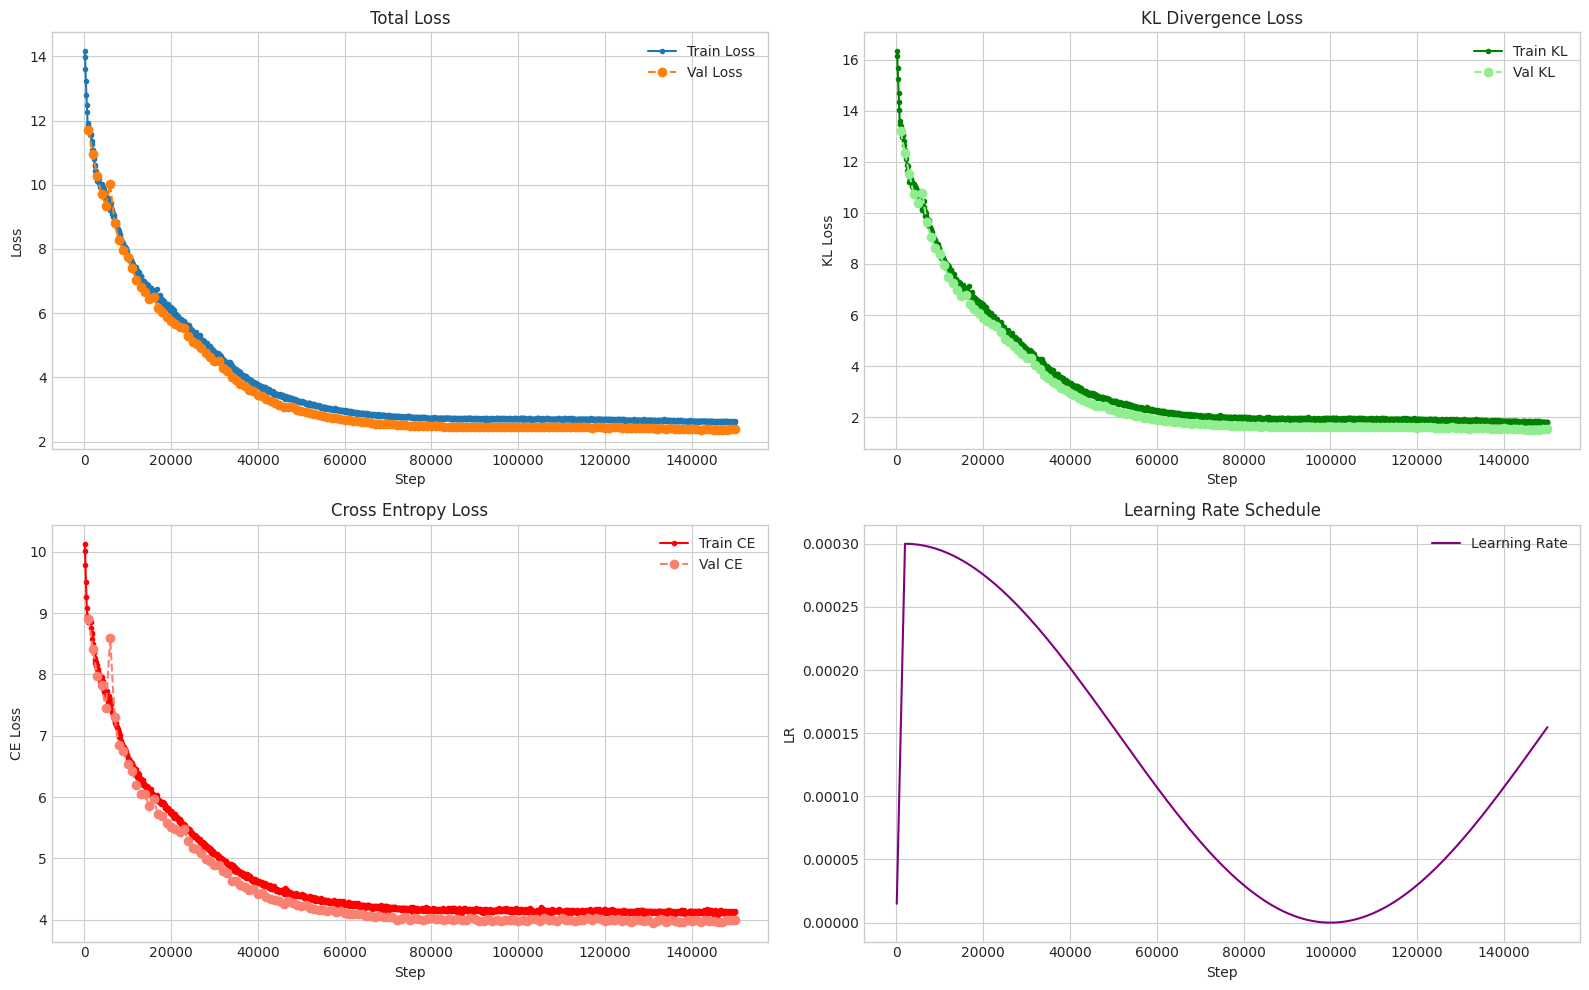

Plots saved to 'training_metrics.png'


In [2]:
parse_and_visualize_logs('/home/krrish/Desktop/Programming/geneformer-scratch/outputs/logs/geneformer_distillation_20251126_112127_metrics.jsonl')

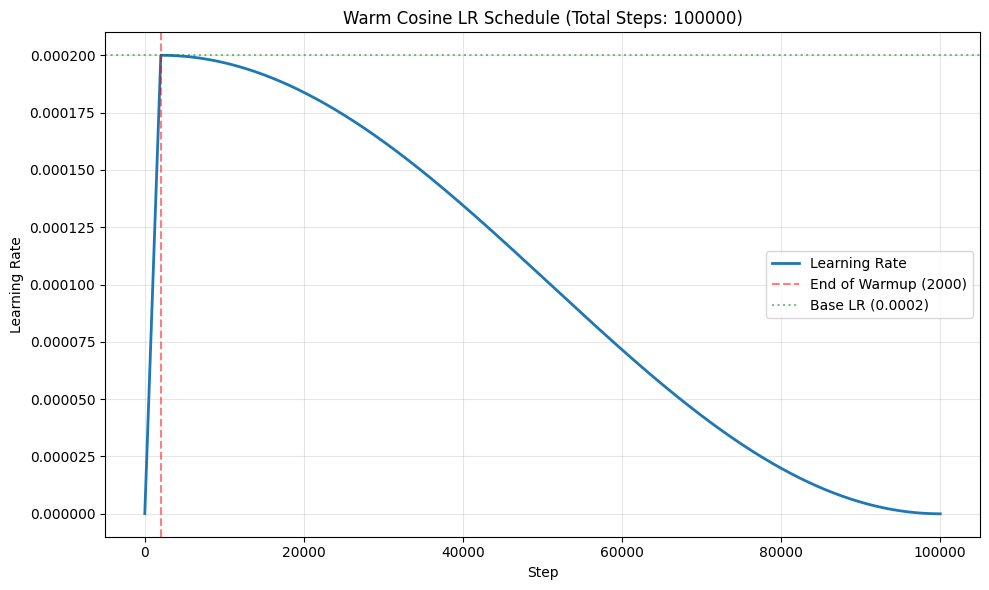

In [1]:
import matplotlib.pyplot as plt
import math

class WarmCosineLR:
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr):
        self.optimizer = optimizer
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(self.warmup_steps + 1, total_steps)
        self.base_lr = base_lr
        self.step_num = 0
        
    def step(self):
        self.step_num += 1
        if self.step_num <= self.warmup_steps:
            lr = self.base_lr * self.step_num / self.warmup_steps
        else:
            progress = (self.step_num - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            progress = min(1.0, progress) 
            lr = 0.5 * self.base_lr * (1.0 + math.cos(math.pi * progress))  
        
        if self.optimizer:
            for g in self.optimizer.param_groups:
                g["lr"] = lr
        return lr


# 1. Configuration
TOTAL_STEPS = 100000
WARMUP_STEPS = 2000   # Example: 5% warmup
BASE_LR = 2e-4        # Example: 0.0002

class MockOptimizer:
    def __init__(self):
        self.param_groups = [{"lr": 0}]

optimizer = MockOptimizer()

scheduler = WarmCosineLR(
    optimizer=optimizer,
    warmup_steps=WARMUP_STEPS,
    total_steps=TOTAL_STEPS,
    base_lr=BASE_LR
)

steps = []
lrs = []

for i in range(TOTAL_STEPS):
    lr = scheduler.step()
    steps.append(i)
    lrs.append(lr)

# 5. Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs, label='Learning Rate', color='#1f77b4', linewidth=2)

plt.axvline(x=WARMUP_STEPS, color='r', linestyle='--', alpha=0.5, label=f'End of Warmup ({WARMUP_STEPS})')
plt.axhline(y=BASE_LR, color='g', linestyle=':', alpha=0.5, label=f'Base LR ({BASE_LR})')

plt.title(f'Warm Cosine LR Schedule (Total Steps: {TOTAL_STEPS})')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('lr_schedule.png')
plt.show()